In [110]:
#from google.colab import drive
#drive.mount('/content/drive')

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report

In [112]:
from sklearn.model_selection import GridSearchCV

In [113]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

# Read Tech Data

In [114]:
data = pd.read_csv('../Data/Tech_cleaned.csv')
data.head(3)

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,Sym,ExpirationDate,index,...,Spent,Sector,ChainLocation,Spent/contract,Spent/share,break_even,Contract period in hrs,Contract period in days,attention,Profit
0,0,10.81,10.97,10.53,10.73,10.73,42128800,AMD,2017-12-01,42368,...,22000,Technology,OTM,220.0,2.2,13.7,172.469722,7,48.0,False
1,1,10.81,10.97,10.53,10.73,10.73,42128800,AMD,2017-12-01,42461,...,32000,Technology,OTM,320.0,3.2,14.7,247.437778,10,48.0,False
2,2,10.81,10.97,10.53,10.73,10.73,42128800,AMD,2017-12-01,42511,...,30000,Technology,OTM,300.0,3.0,14.5,245.110556,10,48.0,False


In [115]:
data.drop(['Unnamed: 0','Unnamed: 0.1', 'Spent', 'Spent/contract', 'Open', 'High', 'Low', 'Time', 'Close', 'Adj Close', 'OptionType', 'Sym', 'Expiration', 'ChainLocation', 'Sector', 'Contract period in days', 'index'], axis=1,inplace=True)
data['ExpirationDate'] = data['ExpirationDate'].astype('datetime64[ns]').map(dt.toordinal)
data['Date'] = data['Date'].astype('datetime64[ns]').map(dt.toordinal)
data['Profit'] = data["Profit"].astype(int)
data=data.reset_index(drop=True)


In [116]:
data.head(3)

,Volume,ExpirationDate,Strike,StockPrice,Date,Spent/share,break_even,Contract period in hrs,attention,Profit
0,42128800,736664,11.5,11.38,736657,2.2,13.7,172.469722,48.0,0
1,42128800,736664,11.5,11.46,736654,3.2,14.7,247.437778,48.0,0
2,42128800,736664,11.5,11.47,736654,3.0,14.5,245.110556,48.0,0


# Split Data 80/20

**Data is very imbalanced, we do not have many positive responses**

In [117]:
X = data.loc[:, data.columns != 'Profit']

In [118]:
y = data.loc[:, data.columns == 'Profit']

In [119]:
X_std = scalar.fit_transform(X)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'Profit'], data.loc[:, data.columns == 'Profit'],random_state = 123, test_size = 0.2)

In [121]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_std, y,random_state = 123, test_size = 0.2)

In [122]:
print("Profit is True: ",y_train[y_train == 1].count()[0])
print("Profit is False: ", y_train[y_train == 0].count()[0])

Profit is True:  81
Profit is False:  4342


In [123]:
print("Profit is True: ",y_test[y_test == 1].count()[0])
print("Profit is False: ", y_test[y_test == 0].count()[0])

Profit is True:  23
Profit is False:  1083


In [124]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [125]:
y_train_s = y_train_s.values.ravel()

# 1.1 KNN

In [126]:
param_range_knn = np.arange(2,25)
train_scores_knn, test_scores_knn = validation_curve(KNeighborsClassifier(weights = "uniform"), X_train, y_train, param_name ="n_neighbors", param_range = param_range_knn, cv = 5)

In [127]:
train_scores_mean_knn = np.mean(train_scores_knn, axis = 1)
test_scores_mean_knn = np.mean(test_scores_knn, axis = 1)
train_scores_std_knn = np.std(train_scores_knn, axis = 1)
test_scores_std_knn = np.std(test_scores_knn, axis = 1)
knn_best = param_range_knn[np.argsort(test_scores_mean_knn)[-1]]
dist = KNeighborsClassifier(n_neighbors = knn_best, weights = "uniform").fit(X_train, y_train)

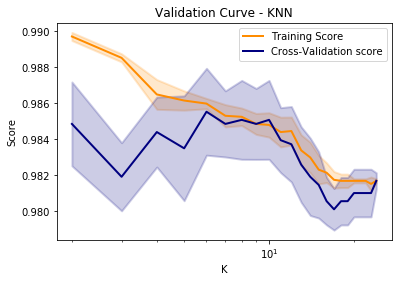

In [128]:
plt.title("Validation Curve - KNN")
plt.xlabel("K")
plt.ylabel("Score")

lw = 2
plt.semilogx(param_range_knn, train_scores_mean_knn, label="Training Score", color="darkorange", lw=lw)
plt.fill_between(param_range_knn, train_scores_mean_knn - train_scores_std_knn, train_scores_mean_knn + train_scores_std_knn, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(param_range_knn, test_scores_mean_knn, label="Cross-Validation score", color="navy", lw=lw)
plt.fill_between(param_range_knn, test_scores_mean_knn - test_scores_std_knn, test_scores_mean_knn + test_scores_std_knn, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [129]:
print("The best parameter K : ", knn_best)
acc_train = dist.score(X_train, y_train)
print('Training accuracy:', acc_train)
print('Test accuracy is:', dist.score(X_test, y_test))

The best parameter K :  6
Training accuracy: 0.9857562740221569
Test accuracy is: 0.9783001808318263


Confusion Matrix with KNN:


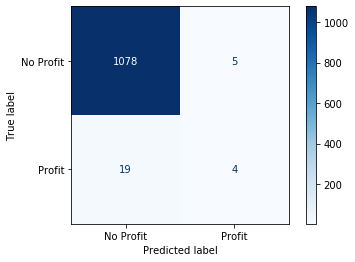

In [130]:
CM_knn = plot_confusion_matrix(dist, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues)
print("Confusion Matrix with KNN:")
plt.show()

**Because of imbalance in the data, the model is bias and predicted over half of the Profit call options incorrectly. We will try SMOTE and NearMiss to see if it can help fix the bias in our KNN model.**

# Synthetic Minority Oversampling Technique (SMOTE)

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106

In [131]:
!pip install imblearn

distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\users\saura\python\python.exe -m pip install --upgrade pip' command.


In [132]:
!pip install delayed

distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\users\saura\python\python.exe -m pip install --upgrade pip' command.


In [133]:
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE
from collections import Counter

0.8.0


In [134]:
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
counter_smote = Counter(y_train_smote)
print(counter_smote)

Counter({0: 4342, 1: 4342})


In [135]:
oversample = SMOTE()
X_train_smote_s, y_train_smote_s = oversample.fit_resample(X_train_s, y_train_s)
counter_smote = Counter(y_train_smote_s)
print(counter_smote)

Counter({0: 4342, 1: 4342})


In [136]:
param_range_knn = np.arange(2,25)
train_scores_knn, test_scores_knn = validation_curve(KNeighborsClassifier(weights = "uniform"), X_train_smote, y_train_smote, param_name ="n_neighbors", param_range = param_range_knn, cv = 5)
train_scores_mean_knn = np.mean(train_scores_knn, axis = 1)
test_scores_mean_knn = np.mean(test_scores_knn, axis = 1)
train_scores_std_knn = np.std(train_scores_knn, axis = 1)
test_scores_std_knn = np.std(test_scores_knn, axis = 1)
knn_best = param_range_knn[np.argsort(test_scores_mean_knn)[-1]]
dist = KNeighborsClassifier(n_neighbors = knn_best, weights = "uniform").fit(X_train_smote, y_train_smote)

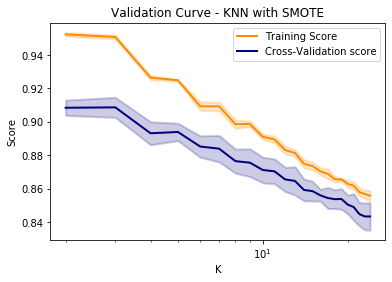

In [137]:
plt.title("Validation Curve - KNN with SMOTE")
plt.xlabel("K")
plt.ylabel("Score")

lw = 2
plt.semilogx(param_range_knn, train_scores_mean_knn, label="Training Score", color="darkorange", lw=lw)
plt.fill_between(param_range_knn, train_scores_mean_knn - train_scores_std_knn, train_scores_mean_knn + train_scores_std_knn, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(param_range_knn, test_scores_mean_knn, label="Cross-Validation score", color="navy", lw=lw)
plt.fill_between(param_range_knn, test_scores_mean_knn - test_scores_std_knn, test_scores_mean_knn + test_scores_std_knn, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [138]:
print("The best parameter K : ", knn_best)
acc_train = dist.score(X_train_smote, y_train_smote)
print('Training accuracy:', acc_train)
print('Test accuracy is:', dist.score(X_test, y_test))

The best parameter K :  3
Training accuracy: 0.9569322892676186
Test accuracy is: 0.9385171790235082


Confusion Matrix with KNN:


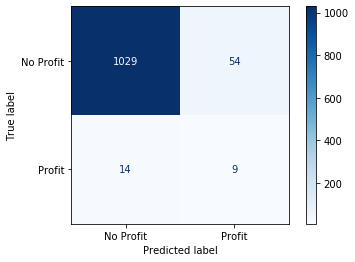

In [139]:
CM_knn = plot_confusion_matrix(dist, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues)
print("Confusion Matrix with KNN:")
plt.show()

In [140]:
y_pred = dist.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1083
           1       0.14      0.39      0.21        23

    accuracy                           0.94      1106
   macro avg       0.56      0.67      0.59      1106
weighted avg       0.97      0.94      0.95      1106



# Under-Sampling Technique

In [141]:
from imblearn.under_sampling import NearMiss

In [142]:
oversample = NearMiss()
X_train_nm, y_train_nm = oversample.fit_resample(X_train, y_train)
counter_nm = Counter(y_train_nm)
print(counter_nm)

Counter({0: 81, 1: 81})


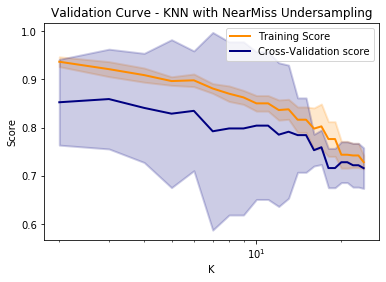

In [143]:
param_range_knn = np.arange(2,25)
train_scores_knn, test_scores_knn = validation_curve(KNeighborsClassifier(weights = "uniform"), X_train_nm, y_train_nm, param_name ="n_neighbors", param_range = param_range_knn, cv = 5)
train_scores_mean_knn = np.mean(train_scores_knn, axis = 1)
test_scores_mean_knn = np.mean(test_scores_knn, axis = 1)
train_scores_std_knn = np.std(train_scores_knn, axis = 1)
test_scores_std_knn = np.std(test_scores_knn, axis = 1)
knn_best = param_range_knn[np.argsort(test_scores_mean_knn)[-1]]
dist = KNeighborsClassifier(n_neighbors = knn_best, weights = "uniform").fit(X_train_nm, y_train_nm)

plt.title("Validation Curve - KNN with NearMiss Undersampling")
plt.xlabel("K")
plt.ylabel("Score")

lw = 2
plt.semilogx(param_range_knn, train_scores_mean_knn, label="Training Score", color="darkorange", lw=lw)
plt.fill_between(param_range_knn, train_scores_mean_knn - train_scores_std_knn, train_scores_mean_knn + train_scores_std_knn, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(param_range_knn, test_scores_mean_knn, label="Cross-Validation score", color="navy", lw=lw)
plt.fill_between(param_range_knn, test_scores_mean_knn - test_scores_std_knn, test_scores_mean_knn + test_scores_std_knn, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [144]:
print("The best parameter K : ", knn_best)
acc_train = dist.score(X_train_nm, y_train_nm)
print('Training accuracy:', acc_train)
print('Test accuracy is:', dist.score(X_test, y_test))

The best parameter K :  3
Training accuracy: 0.9197530864197531
Test accuracy is: 0.20162748643761302


Confusion Matrix with KNN NearMiss Undersampling:


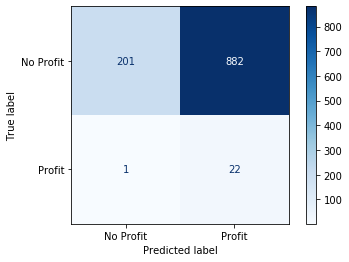

In [145]:
CM_knn = plot_confusion_matrix(dist, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues)
print("Confusion Matrix with KNN NearMiss Undersampling:")
plt.show()

# ADASYN

In [146]:
from imblearn.over_sampling import ADASYN

In [147]:
oversample = ADASYN(sampling_strategy='minority', n_neighbors=5)
X_train_ADASYN, y_train_ADASYN = oversample.fit_resample(X_train, y_train)
counter_ADASYN = Counter(y_train_ADASYN)
print(counter_ADASYN)

Counter({0: 4342, 1: 4338})


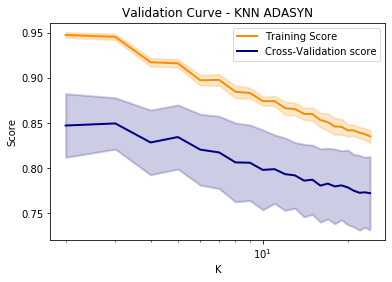

In [148]:
param_range_knn = np.arange(2,25)
train_scores_knn, test_scores_knn = validation_curve(KNeighborsClassifier(weights = "uniform"), X_train_ADASYN, y_train_ADASYN, param_name ="n_neighbors", param_range = param_range_knn, cv = 5)
train_scores_mean_knn = np.mean(train_scores_knn, axis = 1)
test_scores_mean_knn = np.mean(test_scores_knn, axis = 1)
train_scores_std_knn = np.std(train_scores_knn, axis = 1)
test_scores_std_knn = np.std(test_scores_knn, axis = 1)
knn_best = param_range_knn[np.argsort(test_scores_mean_knn)[-1]]
dist = KNeighborsClassifier(n_neighbors = knn_best, weights = "uniform").fit(X_train_nm, y_train_nm)

plt.title("Validation Curve - KNN ADASYN")
plt.xlabel("K")
plt.ylabel("Score")

lw = 2
plt.semilogx(param_range_knn, train_scores_mean_knn, label="Training Score", color="darkorange", lw=lw)
plt.fill_between(param_range_knn, train_scores_mean_knn - train_scores_std_knn, train_scores_mean_knn + train_scores_std_knn, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(param_range_knn, test_scores_mean_knn, label="Cross-Validation score", color="navy", lw=lw)
plt.fill_between(param_range_knn, test_scores_mean_knn - test_scores_std_knn, test_scores_mean_knn + test_scores_std_knn, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [149]:
print("The best parameter K : ", knn_best)
acc_train = dist.score(X_train_ADASYN, y_train_ADASYN)
print('Training accuracy:', acc_train)
print('Test accuracy is:', dist.score(X_test, y_test))

The best parameter K :  3
Training accuracy: 0.5299539170506913
Test accuracy is: 0.20162748643761302


Confusion Matrix with KNN ADASYN:


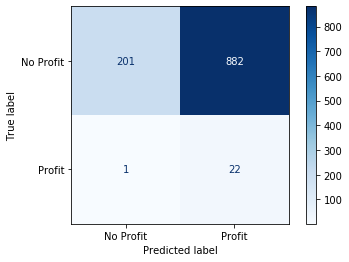

In [150]:
CM_knn = plot_confusion_matrix(dist, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues)
print("Confusion Matrix with KNN ADASYN:")
plt.show()

##### From the results, we can say that out of SMOTE, ADASYN and NearMiss technique, SMOTE works best for our data-set and will be used for testing other models.

# 1.2 SVM

In [151]:
def svm_val_curv(param_range, model, xt,yt):
  # select from the range
  print("param range:", param_range)
  #test for values of C and set cross validation to 5
  train_scores, test_scores = validation_curve(
    model, xt,yt, param_name="C", param_range=param_range,
      scoring="accuracy", n_jobs=1, cv = 5)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  print("test scores mean:", test_scores_mean)

  # Plot CV error as a function of C
  plt.title("Validation Curve with SVM")
  plt.xlabel("C parameter")
  plt.ylabel("Score")
  lw = 2
  plt.semilogx(param_range, train_scores_mean, label="Training score",
              color="darkorange", lw=lw)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.2,
                  color="darkorange", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
              color="navy", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.2,
                  color="navy", lw=lw)
  plt.legend(loc="best")
  plt.show()
  return test_scores_mean

### SMOTE

In [152]:
svc_model_rbf_smote = SVC(kernel = 'rbf', probability=True)

#### RBF

In [153]:
param_range = np.logspace(-5,5, 6)

param range: [1.e-05 1.e-03 1.e-01 1.e+01 1.e+03 1.e+05]
test scores mean: [0.50783423 0.50771909 0.58924466 0.61527078 0.68251899 0.68263214]


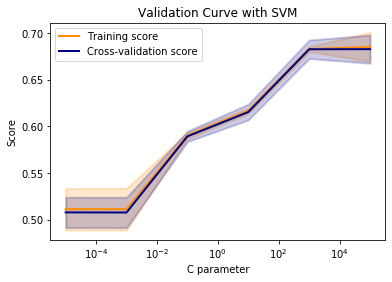

In [154]:
test_scores_mean = svm_val_curv(param_range, svc_model_rbf_smote,X_train_smote, y_train_smote)

In [156]:
C_best = param_range[np.argsort(test_scores_mean)[-1]]
print("The best hyperparameter: ", C_best)

The best hyperparameter:  100000.0


In [157]:
dist = SVC(kernel='rbf',C = C_best, probability = True)
dist.fit(X_train_smote, y_train_smote)

SVC(C=100000.0, probability=True)

In [158]:
acc_train = dist.score(X_train_smote, y_train_smote)
acc_test = dist.score(X_test, y_test)

In [159]:
print('Training accuracy:', acc_train)
print('Test accuracy:', acc_test)

Training accuracy: 0.6915016121602948
Test accuracy: 0.783001808318264


Confusion Matrix with RBF SVM SMOTE:


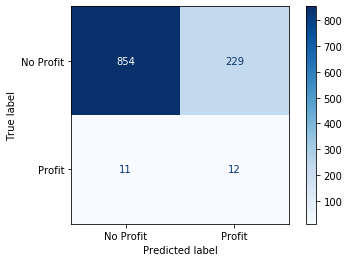

In [160]:
CM_svm = plot_confusion_matrix(dist, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues)
print("Confusion Matrix with RBF SVM SMOTE:")
plt.show()

In [161]:
y_pred = dist.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1083
           1       0.05      0.52      0.09        23

    accuracy                           0.78      1106
   macro avg       0.52      0.66      0.48      1106
weighted avg       0.97      0.78      0.86      1106



# 1.3 Neural Networks

In [162]:
!pip install keras

distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\users\saura\python\python.exe -m pip install --upgrade pip' command.


In [163]:
!pip install tensorflow

distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\saura\python\Include\UNKNOWN
sysconfig: c:\users\saura\python\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\users\saura\python\python.exe -m pip install --upgrade pip' command.


In [164]:
activation_funcs = ['logistic', 'relu'] 
param_grid = dict(hidden_layer_sizes = [(20,10),(40,20),(20,40,20)], early_stopping = [True, False], activation = activation_funcs, batch_size = [32,64], alpha = [0.0001,0.001,0.01])
grid = GridSearchCV(MLPClassifier(), param_grid = param_grid)

In [165]:
grid.fit(X_train_smote, y_train_smote)

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01], 'batch_size': [32, 64],
                         'early_stopping': [True, False],
                         'hidden_layer_sizes': [(20, 10), (40, 20),
                                                (20, 40, 20)]})

In [166]:
print("The best performing Neural Network model has following paramters: ", grid.best_params_)

The best performing Neural Network model has following paramters:  {'activation': 'relu', 'alpha': 0.001, 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (40, 20)}


In [167]:
dist_nn = MLPClassifier(hidden_layer_sizes = (40,20), activation = 'relu', alpha = 0.0001, batch_size = 32, early_stopping = True, random_state = 0).fit(X_train_smote, y_train_smote)

In [168]:
acc_train = dist_nn.score(X_train_smote, y_train_smote)
print('Training accuracy:', acc_train)
print('Test accuracy is:', dist_nn.score(X_test, y_test))

Training accuracy: 0.6279364348226624
Test accuracy is: 0.5958408679927667


In [170]:
y_pred = dist_nn.predict(X_test)
np.unique(y_pred)

array([0, 1])

In [171]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      1083
           1       0.04      0.78      0.07        23

    accuracy                           0.60      1106
   macro avg       0.52      0.69      0.41      1106
weighted avg       0.97      0.60      0.73      1106



Confusion Matrix with NN:


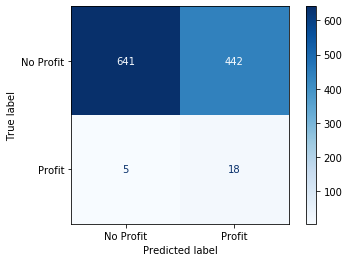

In [172]:
CM_nn = plot_confusion_matrix(dist_nn, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues)
print("Confusion Matrix with NN:")
plt.show()

# 1.4  Logistic Classification

In [173]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_std = scalar.fit_transform(X_train_smote)
X_std_train_smote = scalar.fit_transform(X_train_smote)
X_std_test = scalar.fit_transform(X_test)

In [174]:
from sklearn.linear_model import LogisticRegression

In [175]:
c_range = np.logspace(-4, 6, 6)

In [176]:
train_scores_l2, valid_scores_l2 = validation_curve(LogisticRegression(solver='lbfgs', max_iter = 1000), X_train_smote_s, y_train_smote_s, param_name = "C", param_range = c_range, cv=5)

In [177]:
train_scores_mean_l2 = np.mean(train_scores_l2, axis = 1)
test_scores_mean_l2 = np.mean(valid_scores_l2, axis = 1)
train_scores_std_l2 = np.std(train_scores_l2, axis = 1)
test_scores_std_l2 = np.std(valid_scores_l2, axis = 1)

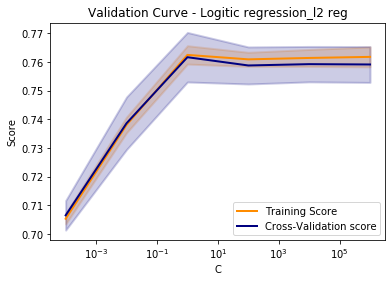

In [178]:
plt.title("Validation Curve - Logitic regression_l2 reg")
plt.xlabel("C")
plt.ylabel("Score")

lw = 2
plt.semilogx(c_range, train_scores_mean_l2, label="Training Score", color="darkorange", lw=lw)
plt.fill_between(c_range, train_scores_mean_l2 - train_scores_std_l2, train_scores_mean_l2 + train_scores_std_l2, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(c_range, test_scores_mean_l2, label="Cross-Validation score", color="navy", lw=lw)
plt.fill_between(c_range, test_scores_mean_l2 - test_scores_std_l2, test_scores_mean_l2 + test_scores_std_l2, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [179]:
c_best = c_range[np.argsort(test_scores_mean_l2)[-1]]
print("The best hyperparameter C is: ", c_best)

The best hyperparameter C is:  1.0


In [180]:
LR_l2 = LogisticRegression(solver='lbfgs',C = c_best).fit(X_train_smote_s, y_train_smote_s)

In [181]:
test_scores_mean_l2

array([0.70647164, 0.73859845, 0.76162925, 0.75875065, 0.75921115,
       0.75909601])

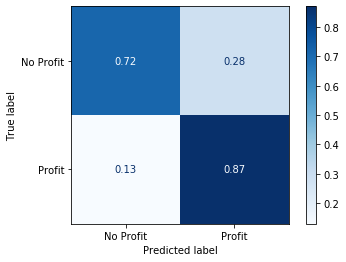

In [183]:
plot_confusion_matrix(LR_l2, X_test_s, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues, normalize = 'true')

In [184]:
y_pred = LR_l2.predict(X_test_s)

In [185]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.72      0.83      1083
           1       0.06      0.87      0.11        23

    accuracy                           0.72      1106
   macro avg       0.53      0.79      0.47      1106
weighted avg       0.98      0.72      0.82      1106



# 1.5 Decision Trees

In [186]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [211]:
max_depth = np.arange(10,50,2)

In [212]:
train_scores_dc, valid_scores_dc= validation_curve(DecisionTreeClassifier(), X_train_smote, y_train_smote, param_name = "max_depth", param_range = max_depth, cv=5)

In [213]:
train_scores_mean_dc = np.mean(train_scores_dc, axis = 1)
test_scores_mean_dc = np.mean(valid_scores_dc, axis = 1)
train_scores_std_dc = np.std(train_scores_dc, axis = 1)
test_scores_std_dc = np.std(valid_scores_dc, axis = 1)

In [214]:
test_scores_mean_dc

array([0.95036758, 0.96015549, 0.96648911, 0.96994368, 0.97074986,
       0.97190154, 0.97178626, 0.97178607, 0.97270786, 0.97144097,
       0.97213169, 0.97178626, 0.97190141, 0.97063466, 0.97224703,
       0.97213162, 0.97259245, 0.97201648, 0.97167086, 0.97236204])

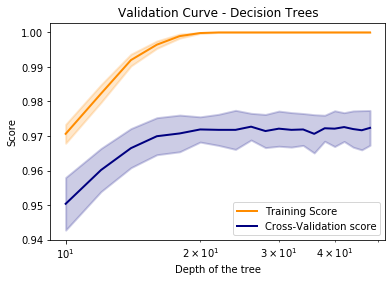

In [215]:
plt.title("Validation Curve - Decision Trees")
plt.xlabel("Depth of the tree")
plt.ylabel("Score")

lw = 2
plt.semilogx(max_depth, train_scores_mean_dc, label="Training Score", color="darkorange", lw=lw)
plt.fill_between(max_depth, train_scores_mean_dc - train_scores_std_dc, train_scores_mean_dc + train_scores_std_dc, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(max_depth, test_scores_mean_dc, label="Cross-Validation score", color="navy", lw=lw)
plt.fill_between(max_depth, test_scores_mean_dc - test_scores_std_dc, test_scores_mean_dc + test_scores_std_dc, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [216]:
depth_best = max_depth[np.argsort(test_scores_mean_dc)[-1]]
print("The best Depth of the tree is: ", depth_best)

The best Depth of the tree is:  26


In [217]:
DC_m1 = DecisionTreeClassifier(max_depth = depth_best, random_state=0).fit(X_train_smote, y_train_smote)

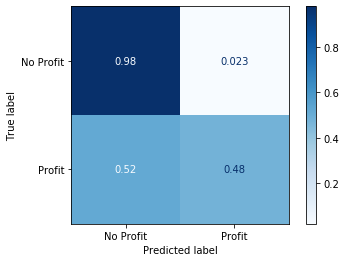

In [218]:
plot_confusion_matrix(DC_m1, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues, normalize='true')

In [219]:
y_pred = DC_m1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1083
           1       0.31      0.48      0.37        23

    accuracy                           0.97      1106
   macro avg       0.65      0.73      0.68      1106
weighted avg       0.97      0.97      0.97      1106



# 1.6 Random Forest

In [196]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc=RFC(random_state=0)

In [197]:
param_grid = { 
    'n_estimators': np.arange(10,200,20),
    'max_depth' : np.arange(10,55,5),
}

In [198]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45, 50]),
                         'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190])})

In [199]:
CV_rfc.best_params_

{'max_depth': 25, 'n_estimators': 190}

In [200]:
rfc1=RFC(random_state=0, n_estimators= 190, max_depth=25, criterion='gini')

In [201]:
rfc1.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=25, n_estimators=190, random_state=0)

In [202]:
y_pred_rfc1 = rfc1.predict(X_test)

In [203]:
print(classification_report(y_test, y_pred_rfc1))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1083
           1       0.58      0.48      0.52        23

    accuracy                           0.98      1106
   macro avg       0.78      0.74      0.76      1106
weighted avg       0.98      0.98      0.98      1106



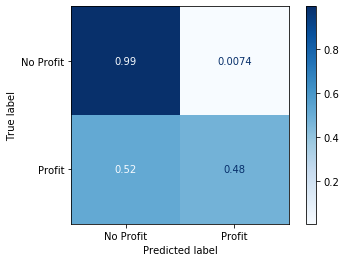

In [204]:
plot_confusion_matrix(rfc1, X_test, y_test, display_labels= ["No Profit", "Profit"], cmap=plt.cm.Blues, normalize='true')

In [210]:
help("modules")


Please wait a moment while I gather a list of all available modules...



C:\Users\saura\Python\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
distributed.dashboard.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
C:\Users\saura\Python\lib\site-packages\nltk\twitter\__init__.py:22: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  "The twython library has not been installed. "
C:\Users\saura\Python\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *
C:\Users\saura\Python\lib\site-packages\qtawesome\iconic_font.py:312: UserWarning: You need to have a running QApplicat

Crypto              calendar            mistune             socketserver
Cython              certifi             mkl                 socks
IPython             cffi                mkl_fft             sockshandler
OpenSSL             cgi                 mkl_random          sortedcollections
PIL                 cgitb               mmap                sortedcontainers
PyQt5               chardet             mmapfile            soupsieve
__future__          chunk               mmsystem            sphinx
_abc                click               mock                sphinxcontrib
_ast                cloudpickle         modulefinder        spyder
_asyncio            clyent              more_itertools      spyder_kernels
_bisect             cmath               mpmath              sqlalchemy
_blake2             cmd                 msgpack             sqlite3
_bootlocale         code                msilib              sre_compile
_bz2                codecs              msvcrt              sre_const

audioop             imagesize           pytrends            win32net
autopep8            imaplib             pytz                win32netcon
autoreload          imblearn            pywin               win32pdh
babel               imghdr              pywin32_bootstrap   win32pdhquery
backcall            imp                 pywin32_testutil    win32pdhutil
backports           importlib           pywintypes          win32pipe
base64              importlib_metadata  pywt                win32print
bcrypt              inspect             pyximport           win32process
bdb                 intervaltree        qdarkstyle          win32profile
binascii            io                  qtawesome           win32ras
binhex              ipaddress           qtconsole           win32rcparser
binstar_client      ipykernel           qtpy                win32security
bisect              ipykernel_launcher  queue               win32service
bitarray            ipython_genutils    quopri              win32s